In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data_path = '/dfs/project/perturb-gnn/datasets/Norman2019_hvg+perts_more_de.h5ad'
adata = sc.read_h5ad(data_path)
gene_list = [f for f in adata.var.gene_symbols.values]

# calculate mean expression for each condition
unique_conditions = adata.obs.condition.unique()
conditions2index = {}
for i in unique_conditions:
    conditions2index[i] = np.where(adata.obs.condition == i)[0]
    
condition2mean_expression = {}
for i, j in conditions2index.items():
    condition2mean_expression[i] = np.mean(adata.X[j], axis = 0)
    
pert_list = np.array(list(condition2mean_expression.keys()))
mean_expression = np.array(list(condition2mean_expression.values())).reshape(len(adata.obs.condition.unique()), adata.X.toarray().shape[1])

ctrl = mean_expression[np.where(pert_list == 'ctrl')[0]]
most_variable_genes = np.argsort(np.std(mean_expression, axis = 0))[-200:]
gene_list = adata.var['gene_name'].values

In [2]:
from scipy import stats
k = 20
def get_fc_AB_C(c):    

    i = np.where(pert_list == c)[0]
    pert = mean_expression[i]
    
    fold_change = pert/ctrl
    fold_change[np.isnan(fold_change)] = 0
    fold_change[np.isinf(fold_change)] = 0

    fold_change[0][np.where(pert[0] < 0.5)[0]] = 0
    
    topk_fold_changes = np.argsort(fold_change)[0][-k:]
    c1 = pert[:, topk_fold_changes].reshape(1,-1)
    c2 = ctrl[:, topk_fold_changes].reshape(1,-1)
    topk_fc_genes = gene_list[topk_fold_changes]
    
    for x in topk_fc_genes:
        for c2 in pert_list:
            if c!=c2 and c2 != 'ctrl' and len(np.intersect1d(parse_any_pert(c), parse_any_pert(c2)))==0:
                parse = parse_any_pert(c2)
                if x in parse and len(parse) == 1:
                    c2_exp = mean_expression[np.where(pert_list == c2)[0]]
                    fc = fold_change[0][np.where(gene_list == parse[0])[0]]
                    if fc[0] > 5:
                        corr_fc.append((c, c2, fc[0], 
                                    stats.pearsonr(c2_exp[:, most_variable_genes][0] - ctrl[:, most_variable_genes][0], 
                                                   pert[:, most_variable_genes][0] - ctrl[:, most_variable_genes][0])[0],
                                    ))
                    
    return corr_fc

In [3]:
from utils import parse_single_pert, parse_any_pert

In [4]:
from tqdm import tqdm
corr_fc = []
for c in tqdm(pert_list):
    if c!='ctrl':
        a = get_fc_AB_C(c)

  0%|                                                                                          | 0/284 [00:00<?, ?it/s]/tmp/ipykernel_52546/3917558323.py:8: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert/ctrl
/tmp/ipykernel_52546/3917558323.py:8: RuntimeWarning: invalid value encountered in true_divide
  fold_change = pert/ctrl
100%|████████████████████████████████████████████████████████████████████████████████| 284/284 [00:41<00:00,  6.77it/s]


/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


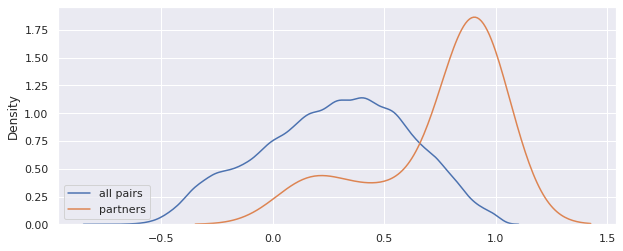

In [5]:
import seaborn as sns
import pandas as pd
sns.set(rc={'figure.figsize':(10, 4)})
import matplotlib.pyplot as plt
corr = pd.DataFrame(mean_expression[:, most_variable_genes] - ctrl[:, most_variable_genes]).T.corr('pearson').values
sns.distplot(corr.reshape(-1,), hist = False, label = 'all pairs')
ax = sns.distplot([i[3] for i in corr_fc], hist = False, label = 'partners')
#ax.set_xlim(0, 1)
plt.legend(loc='lower left', labels=['all pairs', 'partners'])


In [6]:
df_corr_fc = pd.DataFrame(corr_fc)
df_corr_fc = df_corr_fc.rename(columns = {0: 'query_pert', 1: 'act_pert', 
                             2: 'fold_change', 3: 'pearson'})

In [9]:
df_corr_fc

,query_pert,act_pert,fold_change,pearson
0,DUSP9+MAPK1,ctrl+ETS2,7.202773,0.224872
1,DUSP9+MAPK1,ETS2+ctrl,7.202773,0.211482
2,IGDCC3+MAPK1,ctrl+ETS2,6.974825,0.531236
3,IGDCC3+MAPK1,ETS2+ctrl,6.974825,0.515201
4,JUN+CEBPA,ctrl+CEBPE,46.594349,0.910482
5,JUN+CEBPA,CEBPE+ctrl,46.594349,0.890260
6,MAPK1+IKZF3,ctrl+ETS2,6.793534,0.120023
7,MAPK1+IKZF3,ETS2+ctrl,6.793534,0.101036
8,CEBPB+CEBPA,ctrl+CEBPE,57.989193,0.904909
9,CEBPB+CEBPA,CEBPE+ctrl,57.989193,0.886019


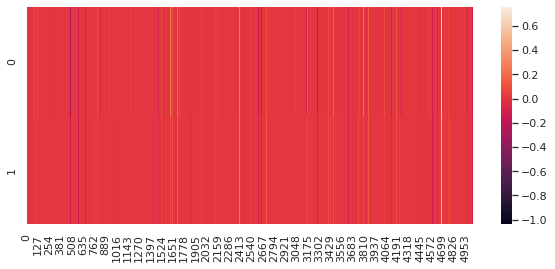

In [12]:
c1 = mean_expression[np.where(pert_list == 'MAPK1+TGFBR2')] - ctrl[0]
c2 = mean_expression[np.where(pert_list == 'ctrl+ETS2')] - ctrl[0]
ax = sns.heatmap(np.vstack((c1.reshape(1,-1), c2.reshape(1,-1))))

<AxesSubplot:>

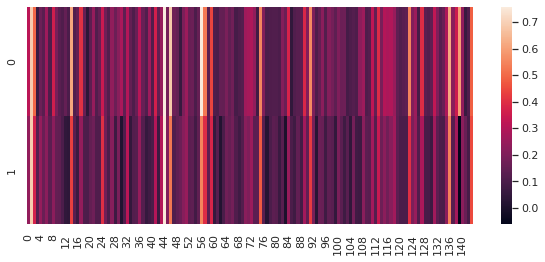

In [25]:
c1_c2_idx = np.union1d(np.where(c1[0] > 0.1)[0], np.where(c2[0] > 0.1)[0])
sns.heatmap(np.vstack((c1[0][c1_c2_idx], c2[0][c1_c2_idx])))

<AxesSubplot:>

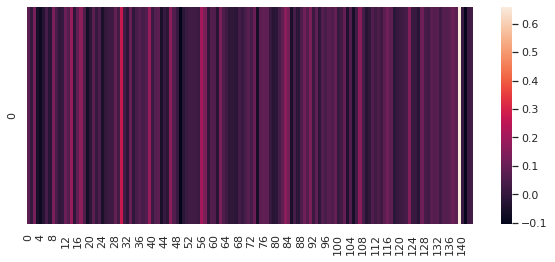

In [34]:
sns.heatmap((c1[0][c1_c2_idx] - c2[0][c1_c2_idx]).reshape(1,-1))

In [38]:
np.argsort(c1[0] - c2[0])

array([2470,  495, 3587, ..., 2084,  903, 4851])

In [39]:
gene_list[4851]

'MAPK1'

In [40]:
gene_list[903]

'TGFBR2'

In [41]:
gene_list[2084]

'TMSB4X'

In [42]:
np.where(gene_list == 'ETS2')

(array([4994]),)

In [43]:
c1[0, 4994]

0.4835991

In [44]:
c2[0, 4994]

0.4489983

In [45]:
ctrl[0, 4994]

0.07508859

/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

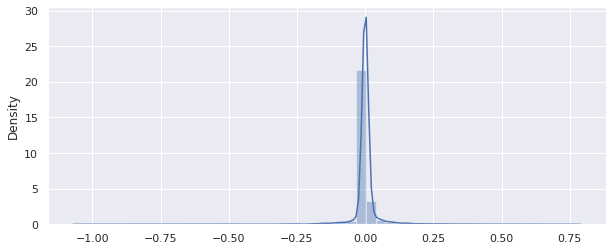

In [22]:
sns.distplot(c1[0])

In [50]:
df = pd.DataFrame(adata.X.toarray())

In [53]:
df_corr_all = df.corr('pearson')

/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

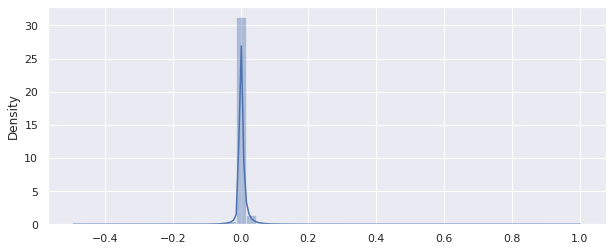

In [56]:
sns.distplot(df_corr_all.values.reshape(-1,))

In [59]:
int_id = np.intersect1d(np.where(df_corr_all > 0.2), np.where(df_corr_all < 1))

In [62]:
len(np.where(df_corr_all > 0.2)[0])

16977

In [ ]:
### build an activation network....
# Given query gene A, find all cells that have high fold-changes... 
# then, go through other genes, and also identify the ones that have high fold changes... 
## check if the pair has fold change linear relationship... 
## => we can also detect direction since if A -> B, then when query is A, we can detect it, but when query is B, we cannot
## what should we do for the genes that are not activated???

In [70]:
ctrl[0]

array([0.0000000e+00, 3.0636375e-03, 7.3340833e-03, ..., 3.7373223e+00,
       8.7353901e-04, 0.0000000e+00], dtype=float32)

In [9]:
import os
os.cpu_count()

80

In [7]:
X = adata.X.toarray()

In [8]:
def get_act_inh(idx):

    fold_change = X[:, idx] / ctrl[0, idx]
    fold_change[np.isnan(fold_change)] = 0
    fold_change[np.isinf(fold_change)] = 0

    high_fc_cells = np.where(fold_change > 2)[0]

    if len(high_fc_cells) > 0:
        high_fc_cells_X = X[high_fc_cells, :]
        high_fc_cells_fc = high_fc_cells_X/ctrl

        high_fc_cells_fc_agg = np.quantile(high_fc_cells_fc, 0.25, axis = 0)
        high_fc_cells_fc_agg[np.isnan(high_fc_cells_fc_agg)] = 0
        high_fc_cells_fc_agg[np.isinf(high_fc_cells_fc_agg)] = 0
        filter_list = np.where(high_fc_cells_fc_agg > 2)[0]

        if len(filter_list)>0:
            activation_network = (gene_list[idx], gene_list[filter_list].to_numpy(), high_fc_cells_fc_agg[filter_list])        
        else:
            activation_network = (gene_list[idx], [], [])
            
        high_fc_cells_fc_agg = np.quantile(high_fc_cells_fc, 0.75, axis = 0)
        high_fc_cells_fc_agg[np.isnan(high_fc_cells_fc_agg)] = 0
        high_fc_cells_fc_agg[np.isinf(high_fc_cells_fc_agg)] = 0

        filter_list = np.intersect1d(np.where(high_fc_cells_fc_agg < 0.5)[0], np.where(high_fc_cells_fc_agg > 0)[0])

        if len(filter_list)>0:
            inhibition_network = (gene_list[idx], gene_list[filter_list].to_numpy(), high_fc_cells_fc_agg[filter_list])
        else:
            inhibition_network = (gene_list[idx], [], [])
    else:
        activation_network = (gene_list[idx], [], [])
        inhibition_network = (gene_list[idx], [], [])
        
    return gene_list[idx], activation_network, inhibition_network

In [9]:
act_all = {}
inh_all = {}

import multiprocessing
p = multiprocessing.Pool(10)
for g, act_n, inh_n in tqdm(p.imap_unordered(get_act_inh, list(range(len(gene_list))))):
    act_all[g] = act_n
    inh_all[g] = inh_n

0it [00:00, ?it/s]/tmp/ipykernel_52546/1069105381.py:3: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = X[:, idx] / ctrl[0, idx]
/tmp/ipykernel_52546/1069105381.py:3: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = X[:, idx] / ctrl[0, idx]
/tmp/ipykernel_52546/1069105381.py:3: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = X[:, idx] / ctrl[0, idx]
/tmp/ipykernel_52546/1069105381.py:3: RuntimeWarning: invalid value encountered in true_divide
  fold_change = X[:, idx] / ctrl[0, idx]
/tmp/ipykernel_52546/1069105381.py:3: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = X[:, idx] / ctrl[0, idx]
/tmp/ipykernel_52546/1069105381.py:3: RuntimeWarning: invalid value encountered in true_divide
  fold_change = X[:, idx] / ctrl[0, idx]
/tmp/ipykernel_52546/1069105381.py:3: RuntimeWarning: invalid value encountered in true_divide
  fold_change = X[:, idx] / ctrl[0, idx]
/tmp/ipykernel_52546/10691

In [10]:
df_act = pd.DataFrame((np.concatenate([np.array([i[0]] * len(i[1])) for i in act_all.values()]),
np.concatenate([np.array(i[1]) for i in act_all.values()]),
np.concatenate([np.array(i[2]) for i in act_all.values()]))).T.rename(columns = {0: 'source',
                                                                                1: 'target',
                                                                                2: 'score'})

In [11]:
df_inh = pd.DataFrame((np.concatenate([np.array([i[0]] * len(i[1])) for i in inh_all.values()]),
np.concatenate([np.array(i[1]) for i in inh_all.values()]),
np.concatenate([np.array(i[2]) for i in inh_all.values()]))).T.rename(columns = {0: 'source',
                                                                                1: 'target',
                                                                                2: 'score'})

In [12]:
df_inh

,source,target,score
0,TNFRSF18,MYC,0.40838
1,CALML6,SLC20A1,0.498418
2,CALML6,MAP1A,0.476338
3,RP1-286D6.5,MT1E,0.434414
4,RP3-395M20.12,CPEB4,0.48216
...,...,...,...
5801,AJ011932.1,FURIN,0.235217
5802,AJ011932.1,TCF4,0.390429
5803,AJ011932.1,DNAJB1,0.354896
5804,AJ011932.1,FCGRT,0.298984


In [13]:
df_act = df_act[df_act.source != df_act.target].reset_index(drop = True)

In [52]:
len(df_act.source.unique())

386

In [53]:
len(df_inh.source.unique())

864

In [54]:
df_act

,source,target,score
0,ESPN,ALAS2,2.445195
1,PIK3CD-AS1,CSF3R,2.384032
2,PIK3CD-AS1,LST1,5.161261
3,PIK3CD-AS1,TRIM56,2.449377
4,PIK3CD-AS1,SAT1,3.557245
...,...,...,...
10887,COL18A1-AS1,MYH9,3.265914
10888,COL18A1-AS1,FAM118A,2.716307
10889,AJ011932.1,MKNK2,2.005467
10890,MT-ND5,MTRNR2L8,3.356656


In [56]:
len(np.unique(df_act[['source', 'target']].values.reshape(-1,)))

2060

In [57]:
len(np.unique(df_inh[['source', 'target']].values.reshape(-1,)))

1420

In [ ]:
### can we check if the inferred data has high similarity against perturbational data?

In [ ]:
### use it as underlying graph?
### use it as data augmentation?


### how to create synthetic perturbations? 
## 1.find the source gene, 
## 2.collect the cells that are activated, 
## 3.find the upstream genes, 
## 4.make them zeros,
## 5.average the cells

In [23]:
from data import PertDataloader, Network

model_name = 'GNN_Disentangle_GAT_string_20.0_64_2_l3_Norman2019_gamma2_gene_emb_pert_emb_constant_lambda_emission'
args = np.load('./saved_args/'+model_name+'.npy', allow_pickle = True).item()
args['test_perts'] = 'N/A'
if args['network_name'] == 'string':
    args['network_path'] = '/dfs/project/perturb-gnn/graphs/STRING_full_9606.csv'

if 'gene_symbols' not in adata.var.columns.values:
    adata.var['gene_symbols'] = adata.var['gene_name']
gene_list = [f for f in adata.var.gene_symbols.values]
# Set up message passing network
network = Network(fname=args['network_path'], gene_list=args['gene_list'],
                  percentile=args['top_edge_percent'])

# Pertrubation dataloader
pertdl = PertDataloader(adata, network.G, network.weights, args)

There are 101013 edges in the PPI.
Creating pyg object for each cell in the data...
Local copy of pyg dataset is detected. Loading...
Loading splits...
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:9
combo_seen1:52
combo_seen2:18
unseen_single:37
Creating dataloaders....
Dataloaders created...


In [24]:
train_perts = pertdl.set2conditions['train']

In [25]:
len(train_perts)

138

In [26]:
len([i for i in train_perts if 'ctrl' in i])

102

In [27]:
X_tr = X[np.isin(adata.obs.condition, [i for i in train_perts if 'ctrl' in i])]

In [28]:
gene_list = adata.var['gene_name'].values

In [253]:
ctrl[0, idx]

0.04442337

In [255]:
def get_act_inh(idx):

    fold_change = (X_tr[:, idx]) / (ctrl[0, idx])
    fold_change[np.isnan(fold_change)] = 0
    fold_change[np.isinf(fold_change)] = 0

    #fold_change[0][np.where(X_tr[:, idx] < 0.5)[0]] = 0

    high_fc_cells = np.where(fold_change > 2)[0]

    if len(high_fc_cells) > 0:
        high_fc_cells_X = X_tr[high_fc_cells, :]
        high_fc_cells_fc = (high_fc_cells_X)/(ctrl)

        high_fc_cells_fc_agg = np.quantile(high_fc_cells_fc, 0.25, axis = 0)
        
        high_fc_cells_fc_agg[np.isnan(high_fc_cells_fc_agg)] = 0
        high_fc_cells_fc_agg[np.isinf(high_fc_cells_fc_agg)] = 0
        filter_list = np.where(high_fc_cells_fc_agg > 2)[0]

        if len(filter_list)>0:
            activation_network = (gene_list[idx], gene_list[filter_list].to_numpy(), high_fc_cells_fc_agg[filter_list])        
        else:
            activation_network = (gene_list[idx], [], [])
            
        high_fc_cells_fc_agg = np.quantile(high_fc_cells_fc, 0.75, axis = 0)
        high_fc_cells_fc_agg[np.isnan(high_fc_cells_fc_agg)] = 0
        high_fc_cells_fc_agg[np.isinf(high_fc_cells_fc_agg)] = 0

        filter_list = np.intersect1d(np.where(high_fc_cells_fc_agg < 0.5)[0], np.where(high_fc_cells_fc_agg > 0)[0])

        if len(filter_list)>0:
            inhibition_network = (gene_list[idx], gene_list[filter_list].to_numpy(), high_fc_cells_fc_agg[filter_list])
        else:
            inhibition_network = (gene_list[idx], [], [])
    else:
        activation_network = (gene_list[idx], [], [])
        inhibition_network = (gene_list[idx], [], [])
        
    return gene_list[idx], activation_network, inhibition_network

In [14]:
act_all = {}
inh_all = {}

import multiprocessing
p = multiprocessing.Pool(4)
for g, act_n, inh_n in tqdm(p.imap_unordered(get_act_inh, list(range(len(gene_list))))):
    act_all[g] = act_n
    inh_all[g] = inh_n
    
    
df_act = pd.DataFrame((np.concatenate([np.array([i[0]] * len(i[1])) for i in act_all.values()]),
np.concatenate([np.array(i[1]) for i in act_all.values()]),
np.concatenate([np.array(i[2]) for i in act_all.values()]))).T.rename(columns = {0: 'source',
                                                                                1: 'target',
                                                                                2: 'score'})

df_inh = pd.DataFrame((np.concatenate([np.array([i[0]] * len(i[1])) for i in inh_all.values()]),
np.concatenate([np.array(i[1]) for i in inh_all.values()]),
np.concatenate([np.array(i[2]) for i in inh_all.values()]))).T.rename(columns = {0: 'source',
                                                                                1: 'target',
                                                                                2: 'score'})

0it [00:00, ?it/s]/tmp/ipykernel_52546/1069105381.py:3: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = X[:, idx] / ctrl[0, idx]
/tmp/ipykernel_52546/1069105381.py:3: RuntimeWarning: invalid value encountered in true_divide
  fold_change = X[:, idx] / ctrl[0, idx]
/tmp/ipykernel_52546/1069105381.py:3: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = X[:, idx] / ctrl[0, idx]
/tmp/ipykernel_52546/1069105381.py:3: RuntimeWarning: invalid value encountered in true_divide
  fold_change = X[:, idx] / ctrl[0, idx]
/tmp/ipykernel_52546/1069105381.py:11: RuntimeWarning: divide by zero encountered in true_divide
  high_fc_cells_fc = high_fc_cells_X/ctrl
/tmp/ipykernel_52546/1069105381.py:11: RuntimeWarning: invalid value encountered in true_divide
  high_fc_cells_fc = high_fc_cells_X/ctrl
2it [00:00, 19.52it/s]/tmp/ipykernel_52546/1069105381.py:11: RuntimeWarning: divide by zero encountered in true_divide
  high_fc_cells_fc = high_fc_cells_X/ctr

In [15]:
df_act = df_act[df_act.source != df_act.target].reset_index(drop = True)
df_inh = df_inh[df_inh.source != df_inh.target].reset_index(drop = True)

In [16]:
df_act

,source,target,score
0,ESPN,ALAS2,2.445195
1,PIK3CD-AS1,CSF3R,2.384032
2,PIK3CD-AS1,LST1,5.161261
3,PIK3CD-AS1,TRIM56,2.449377
4,PIK3CD-AS1,SAT1,3.557245
...,...,...,...
10887,COL18A1-AS1,MYH9,3.265914
10888,COL18A1-AS1,FAM118A,2.716307
10889,AJ011932.1,MKNK2,2.005467
10890,MT-ND5,MTRNR2L8,3.356656


In [17]:
df_inh

,source,target,score
0,TNFRSF18,MYC,0.40838
1,CALML6,SLC20A1,0.498418
2,CALML6,MAP1A,0.476338
3,RP3-395M20.12,CPEB4,0.48216
4,RP3-395M20.12,CNTRL,0.449533
...,...,...,...
5801,AJ011932.1,FURIN,0.235217
5802,AJ011932.1,TCF4,0.390429
5803,AJ011932.1,DNAJB1,0.354896
5804,AJ011932.1,FCGRT,0.298984


In [18]:
len(np.unique(df_act[['source', 'target']].values.reshape(-1,)))

2060

In [19]:
len(np.unique(df_inh[['source', 'target']].values.reshape(-1,)))

1420

In [20]:
len(np.unique(df_act[['source']].values.reshape(-1,)))

386

In [21]:
len(np.unique(df_inh[['source']].values.reshape(-1,)))

864

In [29]:
from utils import parse_any_pert
test_perts_individual_gene = np.unique(np.concatenate([parse_any_pert(i) for i in pertdl.set2conditions['test'] if i != 'ctrl']))

In [30]:
np.intersect1d(np.unique(df_act[['source']].values.reshape(-1,)), test_perts_individual_gene)

array(['CKS1B', 'PRTG', 'TBX3'], dtype=object)

In [31]:
np.intersect1d(np.unique(df_inh[['source']].values.reshape(-1,)), test_perts_individual_gene)

array(['C3orf72', 'CEBPE', 'TGFBR2'], dtype=object)

In [32]:
unseen_single = pertdl.subgroup['test_subgroup']['unseen_single']
test_perts_individual_gene_unseen_single = np.unique(np.concatenate([parse_any_pert(i) for i in unseen_single if i != 'ctrl']))
np.intersect1d(np.unique(df_act[['source']].values.reshape(-1,)), test_perts_individual_gene_unseen_single)

array(['CKS1B'], dtype=object)

In [33]:
np.intersect1d(np.unique(df_inh[['source']].values.reshape(-1,)), test_perts_individual_gene_unseen_single)

array(['C3orf72'], dtype=object)

In [34]:
np.where(gene_list == 'MAML2')[0]

array([2806])

In [35]:
np.where(pert_list == 'MAML2+ctrl')[0]

array([4])

In [36]:
mean_expression[4][2806]

0.18980725

In [37]:
ctrl[0][2806]

0.007094589

In [38]:
perturbation_fold_changes = []

for i in pert_list:
    if i != 'ctrl':
        pert_idx = np.where(pert_list == i)[0][0]
        for x in parse_any_pert(i):
            pert_gene_idx = np.where(gene_list == x)[0][0]
            perturbation_fold_changes.append(mean_expression[pert_idx][pert_gene_idx]/ctrl[0][pert_gene_idx])

/tmp/ipykernel_52546/3954060169.py:8: RuntimeWarning: divide by zero encountered in float_scalars
  perturbation_fold_changes.append(mean_expression[pert_idx][pert_gene_idx]/ctrl[0][pert_gene_idx])


In [39]:
perturbation_fold_changes = np.array(perturbation_fold_changes)

In [40]:
perturbation_fold_changes[np.isnan(perturbation_fold_changes)] = 0

In [41]:
perturbation_fold_changes[np.isinf(perturbation_fold_changes)] = 0

/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

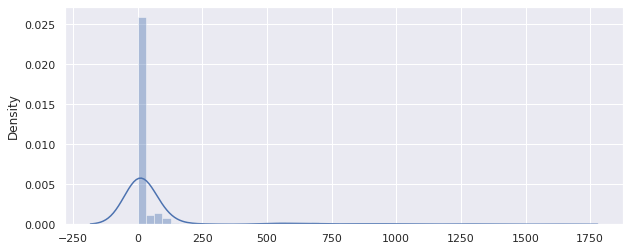

In [42]:
sns.distplot(perturbation_fold_changes)

In [43]:
np.quantile(perturbation_fold_changes, 0.1)

1.5569329977035522

In [44]:
perturbation_fold_changes = []

for i in pert_list:
    if i != 'ctrl':
        pert_idx = np.where(pert_list == i)[0][0]
        for x in parse_any_pert(i):
            pert_gene_idx = np.where(gene_list == x)[0][0]
            perturbation_fold_changes.append(mean_expression[pert_idx][pert_gene_idx] - ctrl[0][pert_gene_idx])

In [45]:
perturbation_fold_changes

[0.953708,
 0.7379499,
 0.03895606,
 1.2906895,
 0.3770253,
 0.18271266,
 1.811097,
 0.21719666,
 0.39406025,
 0.24106601,
 0.47200617,
 0.6448305,
 0.27533934,
 1.4679211,
 0.059242133,
 0.48814058,
 0.2069639,
 0.35873175,
 0.39957705,
 0.20620199,
 0.29311526,
 0.16494328,
 0.41661015,
 1.0329857,
 0.32313922,
 0.055720188,
 0.23504551,
 0.9052858,
 0.06519195,
 0.3056962,
 0.6041485,
 1.6237943,
 0.49149787,
 0.29082352,
 0.2941637,
 0.4489983,
 1.6897632,
 0.45308948,
 0.2683778,
 2.044383,
 0.79623264,
 0.14528517,
 0.17860891,
 0.3449142,
 0.95112664,
 0.4300739,
 0.17766497,
 0.21120971,
 1.290914,
 0.67592084,
 2.024716,
 -0.006602308,
 0.061410867,
 1.1068088,
 0.865472,
 0.38553154,
 0.43510598,
 0.5158615,
 0.4079446,
 0.6279206,
 0.38169765,
 0.3207661,
 -0.0046489313,
 0.18864378,
 2.0674593,
 1.3134935,
 0.3754553,
 0.25369406,
 0.5401551,
 0.5104642,
 1.3256559,
 0.34608757,
 0.45697746,
 1.1249137,
 -0.02282039,
 0.30780295,
 0.5073597,
 0.21743524,
 0.06613,
 0.937764

In [46]:
CKS1B_true = mean_expression[np.where(pert_list == 'CKS1B+ctrl')[0]]

In [47]:
gene_cks1b = np.where(gene_list == 'CKS1B')[0]

In [48]:
gene_cks1b

array([331])

In [49]:
fc_cks1b = X_tr[:, gene_cks1b]/ctrl[0, gene_cks1b]

In [55]:
implicit_pert_cks1b = np.where(fc_cks1b.reshape(-1,) > 2)[0]
implicit_pert_cks1b

array([  153,  2052, 18160, 19776, 23586, 24164, 31808, 32137, 32802])

In [51]:
implicit_pert_cks1b = np.mean(X_tr[implicit_pert_cks1b], axis = 0)

In [54]:
implicit_pert_cks1b

array([0.       , 0.       , 0.       , ..., 3.4628158, 0.       ,
       0.       ], dtype=float32)

In [52]:
stats.pearsonr(implicit_pert_cks1b[most_variable_genes] - ctrl[0, most_variable_genes], 
               CKS1B_true[0, most_variable_genes] - ctrl[0, most_variable_genes])

(0.3183604580951577, 4.344608466499609e-06)

In [53]:
X_tr.shape

(41209, 5045)

In [166]:
implicit_pert_cks1b

array([0.       , 0.       , 0.       , ..., 3.4628158, 0.       ,
       0.       ], dtype=float32)